In [1]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree, remove_self_loops, add_self_loops
from torch_geometric.nn import SAGEConv
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt


class SAGENet(nn.Module):
    def __init__(self):
        super(SAGENet, self).__init__()
        self.conv1 = SAGEConv(dataset.num_features, 16)
        self.conv2 = SAGEConv(16, dataset.num_classes)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Pubmed

In [2]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./dataset/Pubmed', name='Pubmed')

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGENet().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

filename = 'LossAndAccuracy/GraphSAGE_Pubmed.txt'

# List to store loss values
loss_values = []

model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    _, pred = model(data).max(dim=1)
    correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / data.test_mask.sum().item()

    # Store loss value
    loss_values.append(loss.item())

    with open(filename,'a') as f: # 'a'表示append,即在原来文件内容后继续写数据（不清楚原有数据）
        f.write('{:02d} {:.4f} {:.4f}\n'.format(epoch, loss, acc))

In [4]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7660


#  recall and precision 

In [5]:
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.7616
Recall: 0.7661


# ROC and AUC 

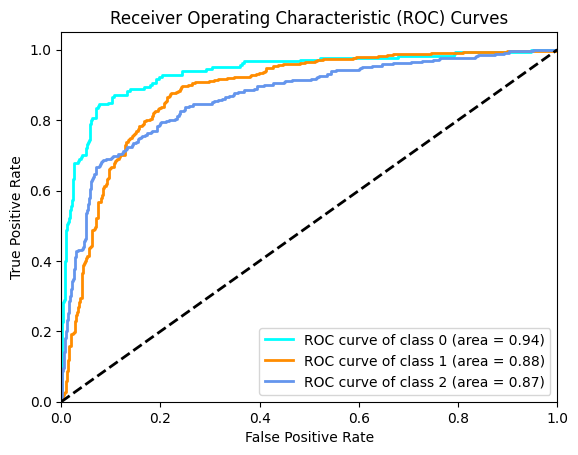

In [6]:
# Calculate ROC and AUC for each class
y_score = model(data)[data.test_mask].detach().cpu().numpy()
n_classes = dataset.num_classes
fpr = dict()
tpr = dict()
roc_auc = dict()

# One-hot encode the true labels
y_true_one_hot = np.eye(n_classes)[y_true]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

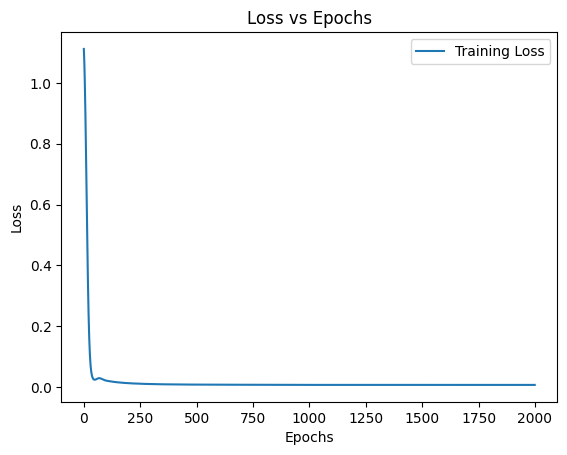

In [7]:
# Plotting loss vs epochs graph
plt.figure()
plt.plot(range(2000), loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

## K Means


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import numpy as np


In [7]:
model.eval()
with torch.no_grad():
    extracted_features = model(data).cpu().numpy()

In [13]:
# Step 2: Perform K-means clustering
kmeans = KMeans(n_clusters=5)  # Start with an arbitrary number of clusters
kmeans.fit(extracted_features)
cluster_labels = kmeans.labels_


In [14]:
# Step 3: Elbow Method to find optimal k
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(extracted_features)
    inertia.append(kmeans.inertia_)

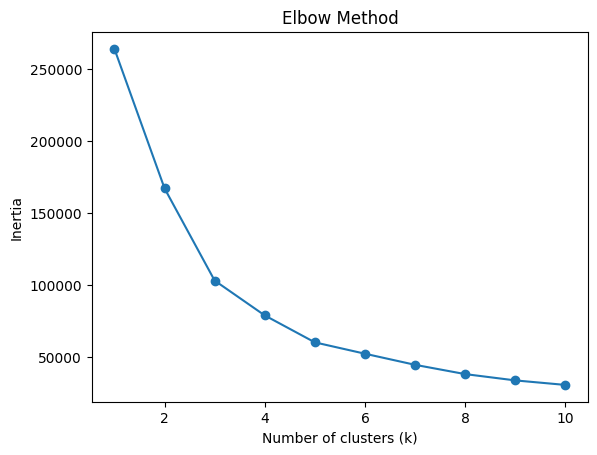

In [16]:
# Plot the elbow method
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [15]:
# Step 5: Calculate ARI and NMI
# Assuming true labels are available
true_labels = data.y.cpu().numpy()  # Assuming data.y contains true labels
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)

Adjusted Rand Index (ARI): 0.2366619510760695
Normalized Mutual Information (NMI): 0.3120785099111935


In [17]:
import networkx as nx

# Convert PyG data to NetworkX graph
def to_networkx(data):
    edge_index = data.edge_index.cpu().numpy()
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    G.add_edges_from(edge_index.T)
    return G

# Assuming 'cluster_labels' contains the cluster assignments
cluster_labels = kmeans.labels_

# Convert PyG data to NetworkX graph
G = to_networkx(data)

# Compute Entropy
def entropy(labels):
    from collections import Counter
    import numpy as np
    counts = np.bincount(labels)
    probabilities = counts / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Compute Entropy
entropy_value = entropy(cluster_labels)

# Compute Density
density = nx.density(G)

# Create a partition of the graph based on cluster labels
partition = []
for label in set(cluster_labels):
    community = set()
    for node, cluster_label in enumerate(cluster_labels):
        if cluster_label == label:
            community.add(node)
    partition.append(community)

# Compute Modularity
modularity = nx.algorithms.community.quality.modularity(G, partition)

# Compute Conductance
conductance = nx.algorithms.cuts.conductance(G, cluster_labels)

print("Entropy:", entropy_value)
print("Density:", density)
print("Modularity:", modularity)
print("Conductance:", conductance)


Entropy: 3.1569414649672836
Density: 0.00022803908825811382
Modularity: 0.4274043550257911
Conductance: 0.0007224780998825973


In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


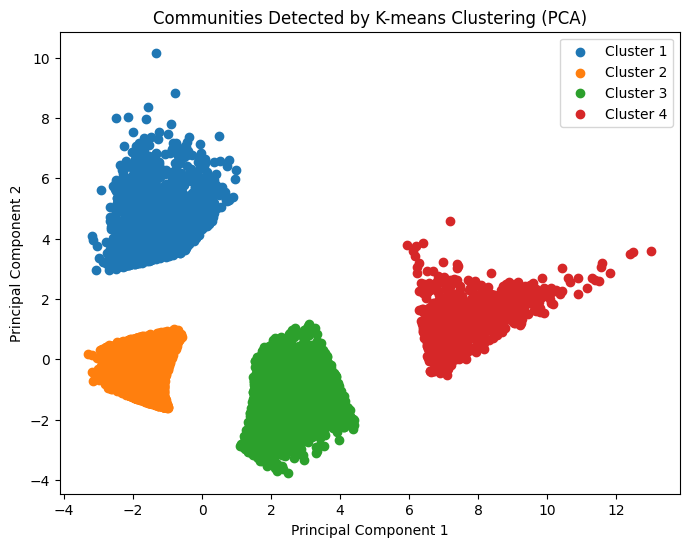

In [19]:
# Reduce the dimensionality of features using PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_features = pca.fit_transform(extracted_features)

# Plot the communities
plt.figure(figsize=(8, 6))
for i in range(4):  # Assuming there are 5 clusters
    plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], label=f'Cluster {i+1}')

plt.title('Communities Detected by K-means Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## Spectral Clustering


In [20]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import numpy as np

In [21]:
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral.fit_predict(extracted_features)

In [22]:
true_labels = data.y.cpu().numpy()  # Assuming data.y contains true labels
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print("Adjusted Rand Index (ARI) for Spectral Clustering:", ari)
print("Normalized Mutual Information (NMI) for Spectral Clustering:", nmi)

Adjusted Rand Index (ARI) for Spectral Clustering: 0.19382672767727288
Normalized Mutual Information (NMI) for Spectral Clustering: 0.290822955832031


In [23]:
import numpy as np
from scipy.sparse import csr_matrix

def compute_entropy(cluster_labels):
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
    label_probs = label_counts / len(cluster_labels)
    entropy = -np.sum(label_probs * np.log2(label_probs))
    return entropy

def compute_density(adj_matrix, cluster_labels):
    num_nodes = adj_matrix.shape[0]
    num_edges_within_clusters = 0
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if cluster_labels[i] == cluster_labels[j] and adj_matrix[i, j] == 1:
                num_edges_within_clusters += 1
    density = num_edges_within_clusters / (num_nodes * (num_nodes - 1) / 2)  # Assuming undirected graph
    return density

def compute_modularity(adj_matrix, cluster_labels):
    num_nodes = adj_matrix.shape[0]
    num_edges = np.sum(adj_matrix) / 2  # Divide by 2 for undirected graph
    modularity = 0
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if cluster_labels[i] == cluster_labels[j]:
                modularity += (adj_matrix[i, j] - (np.sum(adj_matrix[i]) * np.sum(adj_matrix[j]) / (2 * num_edges)))
    modularity /= (2 * num_edges)
    return modularity

def compute_conductance(adj_matrix, cluster_labels):
    num_nodes = adj_matrix.shape[0]
    cut_edges = 0
    inside_degrees = np.zeros(len(np.unique(cluster_labels)))
    outside_degrees = np.zeros(len(np.unique(cluster_labels)))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj_matrix[i, j] == 1:
                if cluster_labels[i] != cluster_labels[j]:
                    cut_edges += 1
                    outside_degrees[cluster_labels[i]] += 1
                    outside_degrees[cluster_labels[j]] += 1
                else:
                    inside_degrees[cluster_labels[i]] += 1
    conductance = cut_edges / min(np.sum(inside_degrees), np.sum(outside_degrees))
    return conductance

# Assuming you have computed cluster_labels from the spectral clustering results

# Construct adjacency matrix
adj_matrix = np.zeros((len(data.y), len(data.y)))
for i, j in zip(data.edge_index[0], data.edge_index[1]):
    adj_matrix[i, j] = 1
    adj_matrix[j, i] = 1

# Compute metrics
entropy = compute_entropy(cluster_labels)
density = compute_density(adj_matrix, cluster_labels)
modularity = compute_modularity(adj_matrix, cluster_labels)
conductance = compute_conductance(adj_matrix, cluster_labels)

print("Entropy:", entropy)
print("Density:", density)
print("Modularity:", modularity)
print("Conductance:", conductance)


Entropy: 2.210071915914369
Density: 0.00016175320221178366
Modularity: 0.23893052269142545
Conductance: 0.5


In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


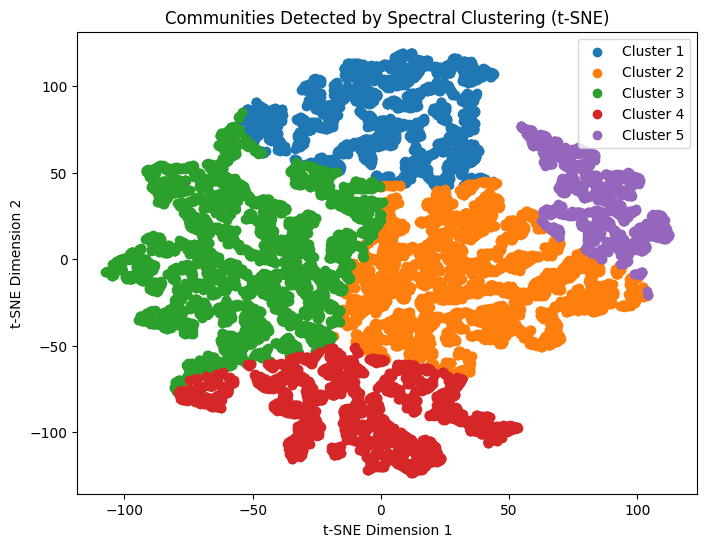

In [25]:
# Reduce the dimensionality of features using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(extracted_features)

# Plot the communities
plt.figure(figsize=(8, 6))
for i in range(5):  # Assuming there are 5 clusters
    plt.scatter(reduced_features[cluster_labels == i, 0], reduced_features[cluster_labels == i, 1], label=f'Cluster {i+1}')

plt.title('Communities Detected by Spectral Clustering (t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

## Louvain algorithm

In [26]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from torch_geometric.utils import to_networkx
import networkx as nx
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import community 

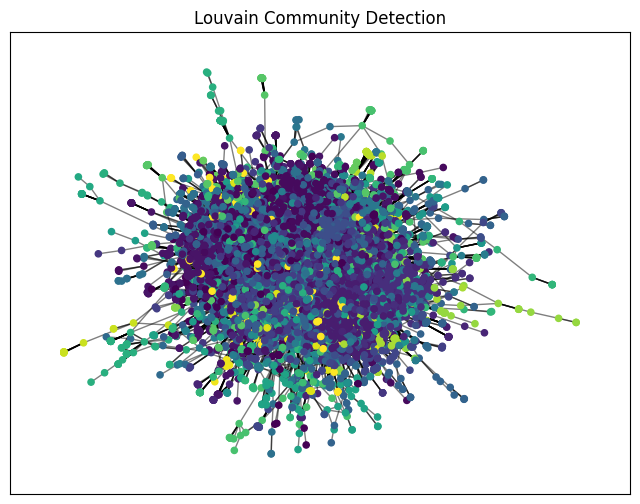

Adjusted Rand Index (ARI): 0.0975
Normalized Mutual Information (NMI): 0.1996


In [27]:
# Extract node features
with torch.no_grad():
    out_features = model.conv2(model.conv1(data.x, data.edge_index), data.edge_index).cpu().numpy()

# Convert to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Perform Louvain community detection
partition = community.best_partition(G, resolution=1.0)

# Visualize communities
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=20, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Louvain Community Detection")
plt.show()

# Calculate ARI and NMI
true_labels = data.y.cpu().numpy()
predicted_labels = np.array([partition[i] for i in range(len(G.nodes()))])
ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)

print("Adjusted Rand Index (ARI): {:.4f}".format(ari))
print("Normalized Mutual Information (NMI): {:.4f}".format(nmi))

In [28]:
from collections import Counter

# Calculate Entropy
def entropy(labels):
    label_counts = Counter(labels)
    total_count = len(labels)
    entropy_val = -sum(count / total_count * np.log2(count / total_count) for count in label_counts.values())
    return entropy_val

# Calculate Density
def density(graph, communities):
    total_density = sum(nx.density(graph.subgraph(community)) for community in communities)
    return total_density / len(communities)

# Calculate Modularity
def modularity(graph, partition):
    modularity_val = community.modularity(partition, graph)
    return modularity_val

# Calculate Conductance
def conductance(graph, partition):
    conductance_vals = []
    for community_id in set(partition.values()):
        community_nodes = [node for node, com_id in partition.items() if com_id == community_id]
        boundary_edges = sum(1 for u, v in graph.edges(community_nodes) if partition[u] != partition[v])
        total_degree = sum(graph.degree(node) for node in community_nodes)
        conductance_val = boundary_edges / total_degree if total_degree > 0 else 0
        conductance_vals.append(conductance_val)
    avg_conductance = sum(conductance_vals) / len(conductance_vals)
    return avg_conductance


# Convert community partition to list of communities
communities = [[] for _ in range(max(partition.values()) + 1)]
for node, community_id in partition.items():
    communities[community_id].append(node)

# Calculate metrics
entropy_val = entropy(partition.values())
density_val = density(G, communities)
modularity_val = modularity(G, partition)
conductance_val = conductance(G, partition)

print("Entropy: {:.4f}".format(entropy_val))
print("Density: {:.4f}".format(density_val))
print("Modularity: {:.4f}".format(modularity_val))
print("Conductance: {:.4f}".format(conductance_val))


Entropy: 4.4141
Density: 0.0428
Modularity: 0.7726
Conductance: 0.1435


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
data_cora =np.loadtxt("LossAndAccuracy/GraphSAGE_Pubmed.txt")

x = data_cora[:,0] # epoch
y1 = data_cora[:,1] # loss
y2 = data_cora[:,2] # accuracy

Text(0.5, 1.0, 'loss for training GraphSAGE on pubmed')

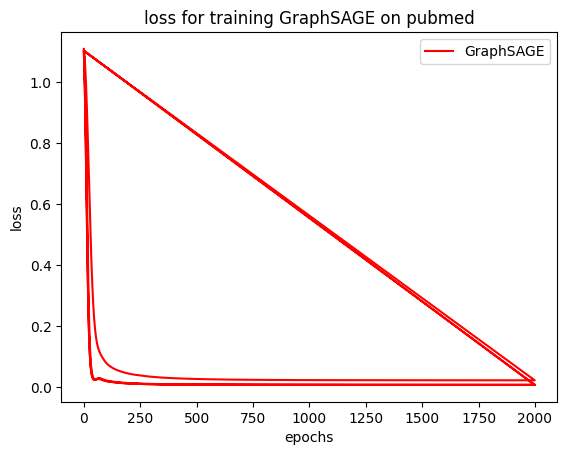

In [30]:
# 画出整体的loss曲线

p2 = pl.plot(x, y1,'r-', label = u'GraphSAGE')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GraphSAGE on pubmed')

Text(0.5, 1.0, 'accuracy for training GraphSAGE on pubmed')

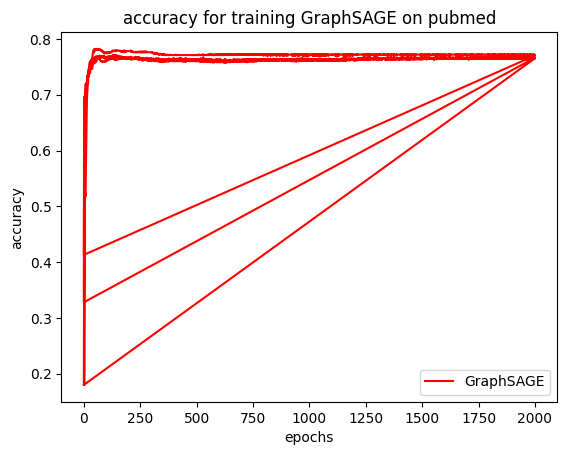

In [31]:
# 画出整体的accuracy曲线

p2 = pl.plot(x, y2,'r-', label = u'GraphSAGE')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GraphSAGE on pubmed')

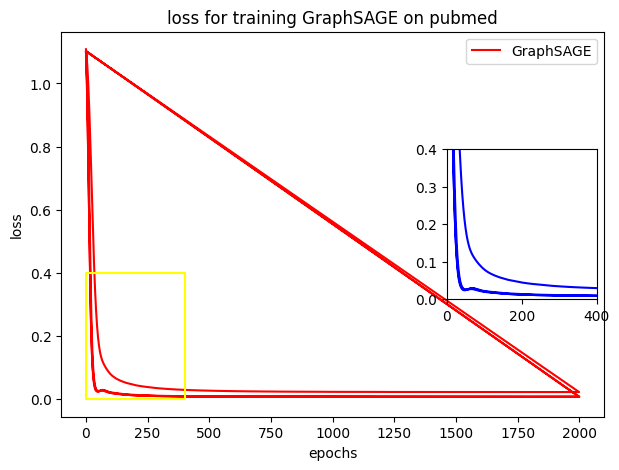

In [32]:
fig1 = plt.figure(figsize = (7,5)) # figsize是图片的大小`
ax1 = fig1.add_subplot(1, 1, 1) # ax1是子图的名字`

# 画出整体的loss曲线
p2 = pl.plot(x, y1,'r-', label = u'GraphSAGE')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'loss')
plt.title('loss for training GraphSAGE on pubmed')

# 显示放大的部分曲线
tx0 = 0
tx1 = 400
ty0 = 0.000
ty1 = 0.40
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y1, color='blue', ls='-')
axins.axis([0, 400, 0.000, 0.40])
plt.savefig("graphs/GraphSAGE_pubmed_loss.png")
pl.show()

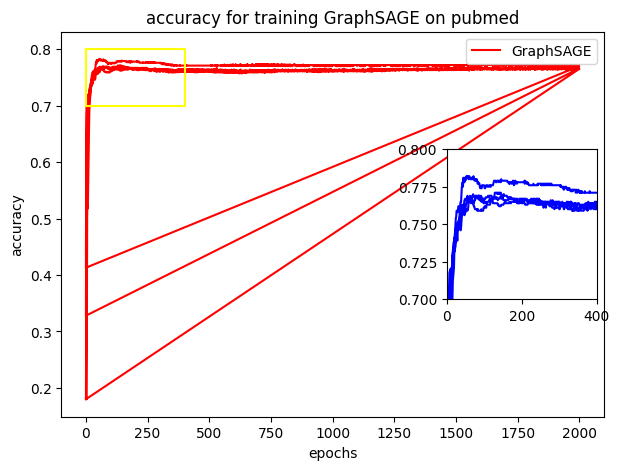

In [33]:
fig1 = plt.figure(figsize = (7,5)) # figsize是图片的大小`
ax1 = fig1.add_subplot(1, 1, 1) # ax1是子图的名字`

# 画出整体的loss曲线

p2 = pl.plot(x, y2,'r-', label = u'GraphSAGE')
pl.legend()
#显示图例
pl.xlabel(u'epochs')
pl.ylabel(u'accuracy')
plt.title('accuracy for training GraphSAGE on pubmed')

# 显示放大的部分曲线
tx0 = 0
tx1 = 400
#设置想放大区域的横坐标范围
ty0 = 0.70
ty1 = 0.80
#设置想放大区域的纵坐标范围
sx = [tx0,tx1,tx1,tx0,tx0]
sy = [ty0,ty0,ty1,ty1,ty0]
pl.plot(sx,sy,"yellow")
axins = inset_axes(ax1, width=1.5, height=1.5, loc='right')

axins.plot(x,y2, color='blue', ls='-')
axins.axis([0, 400, 0.70, 0.80])
plt.savefig("graphs/GraphSAGE_pubmed_accuracy.png")
pl.show()

In [34]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.lin_l.weight 	 torch.Size([16, 500])
conv1.lin_l.bias 	 torch.Size([16])
conv1.lin_r.weight 	 torch.Size([16, 500])
conv2.lin_l.weight 	 torch.Size([3, 16])
conv2.lin_l.bias 	 torch.Size([3])
conv2.lin_r.weight 	 torch.Size([3, 16])
Optimizer's state_dict:
state 	 {0: {'step': tensor(2000.), 'exp_avg': tensor([[ 4.1563e-07, -6.8023e-08,  5.8840e-08,  ...,  6.6967e-08,
         -5.8504e-08, -5.2743e-10],
        [-9.1826e-07, -3.0234e-09,  1.7769e-07,  ..., -1.1706e-07,
          5.2790e-08,  7.3112e-08],
        [-1.5955e-07, -4.1007e-09,  2.2819e-08,  ...,  4.1004e-08,
          2.0960e-08,  1.8523e-08],
        ...,
        [ 1.0281e-07,  9.4285e-08,  1.2914e-07,  ...,  6.3874e-08,
          9.2119e-09, -2.2411e-08],
        [ 8.8215e-08,  6.8798e-09, -8.3835e-08,  ..., -3.5991e-09,
         -2.1987e-08,  4.4721e-09],
        [-3.2777e-07, -7.7235e-08,  2.0981e-07,  ...,  7.4880e-08,
          1.4055e-08,  5.5029e-09]]), 'exp_avg_sq': tensor([[1.1203e-09, 4.

In [44]:
torch.save(model.state_dict(),'SAGEpubmed.pkl')